## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)

<hr style="height:1px;border-top:4px solid #FF8200" />

# Working with Spectrum Images


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Content

Plotting, Interacting and Quantifying Spectrum Image data

Please cite for core-loss quantification:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## First we import the relevant packages

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

from scipy.ndimage.filters import gaussian_filter

# import pyTEMlib packages
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import EELS_tools  as eels 

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib


C:\Users\gdusc\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


windows
pyTEM version:  0.6.2019.5


# Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

<IPython.core.display.Javascript object>


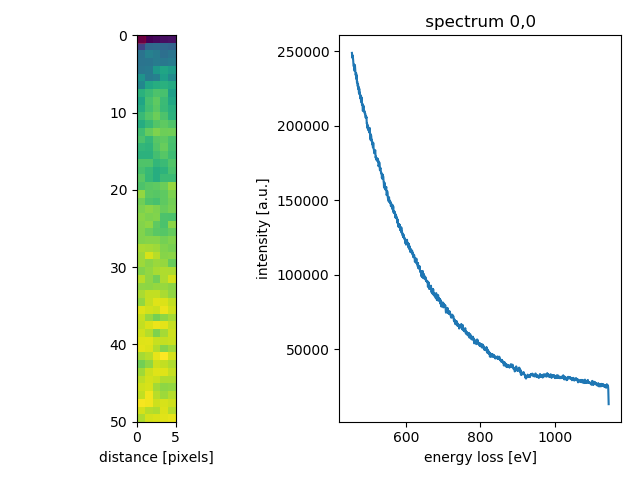

In [4]:
# Load file
try:
    h5_file.close()
    pass
except:
    pass
h5_file = ft.h5_open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

     
if current_channel['data_type'][()] == 'spectrum_image':
    if 'intentsity_scale_ppm' not  in current_channel:
        current_channel['intentsity_scale_ppm'] = 1   
else:    
    print('NOT what we want here, please select a spectrum image ')
    
view= ft.h5_plot(current_channel) # note this needs a view reference for interaction
 

## Make dictionary for plotting and analysis of spectrum image

In [5]:
# get dictionary from current channel in pyUSID file
tags = ft.h5_get_dictionary(current_channel)
energy_scale_orig = tags['energy_scale']

# plot data

if tags['data_type']== 'spectrum_image':
    tags['image'] = tags['data']
    tags['data'] = tags['cube'][0,0,:]
    if 'intentsity_scale_ppm' not  in current_channel:
        current_channel['intentsity_scale_ppm'] = 1
        
    tags['ylabel'] = 'intensity [a.u.]'
    tags['spectra'] = {}
    for x in range(tags['spatial_size_y']):
        for y in range(tags['spatial_size_x']):
            tags['spectra'][f'{x}-{y}'] ={}
            tags['spectra'][f'{x}-{y}']['spectrum'] = tags['cube'][y,x,:]
            tags['spectra'][f'{x}-{y}']['energy_scale'] = tags['energy_scale']
            tags['spectra'][f'{x}-{y}']['intensity_scale'] = 1/tags['cube'][y,x,:].sum()*1e6
    tags['ylabel'] = 'inel. scat. int.  [ppm]'
    
if 'acceleration_voltage' not in tags:
    print('Acceleration voltage is not set, unable to proceed')
    
if 'collection_angle' not in tags:
    print('Acceleration voltage is not set, unable to proceed')

In [ ]:
for x in range(tags['spatial_size_y']):
    for y in range(tags['spatial_size_x']):
        spectrum = tags['spectra'][f'{x}-{y}']['spectrum']
        energy_scale = tags['spectra'][f'{x}-{y}']['energy_scale']
        FWHM, dE = eels.fixE(spectrum, energy_scale)
        
        tags['spectra'][f'{x}-{y}']['energy_scale'] = energy_scale-dE
        tags['spectra'][f'{x}-{y}']['FWHM'] = FWHM
            

## Interactive Spectrum image Plot:
   
Here is the code that makes the plot interactive

Box(children=(ToggleButton(value=False, description='fix_energy'), ToggleButton(value=False, description='fit_…

<IPython.core.display.Javascript object>


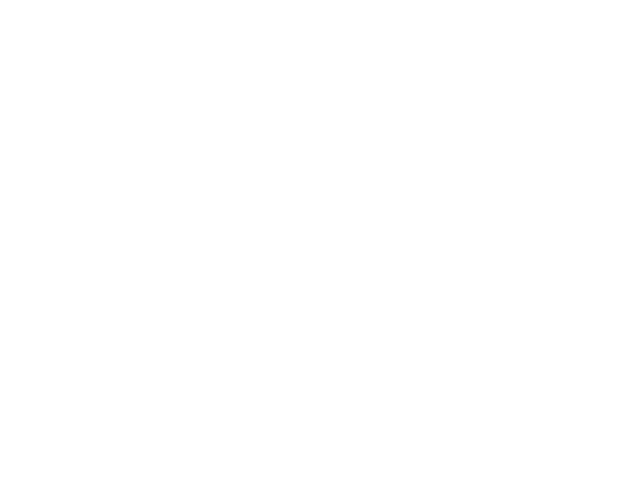

NameError: name 'tags' is not defined

In [5]:
import matplotlib.patches as patches
from ipywidgets import widgets


class interactive_spectrum_image(object):
    """    
    ### Interactive spectrum imaging plot
    
    Input tags: dictionary with a minumum of the following keys:
        ['image']: displayed image  
        ['data']:  data cube
        ['intentsity_scale_ppm']: intensity scale         
        ['ylabel']: intensity label
        ['spectra'] dictionary which contains dictionaries for each spectrum style ['1-2']:
            ['spectrum'] = tags['cube'][y,x,:]
            ['spectra'][f'{x}-{y}']['energy_scale'] = tags['energy_scale']
            ['intensity_scale'] = 1/tags['cube'][y,x,:].sum()*1e6
    
    Please note the possibility to load any image for the selection of the spectrum
    Also there is the possibilty to display the survey image.
    
    For analysis we have the following options:
        'fix_energy': set zero-loss peak maximum to zero !! Low loss spectra only!!
        'fit_zero_loss': fit zero-loss peak with model function !! Low loss spectra only!!
        'fit_low_loss': fit low-loss spectrum with model peaks !! Low loss spectra only!!
        
        
        'fit_composition': fit core-loss spectrum with background and cross sections!! Core loss spectra only!!
        'fit_ELNES': fit core-loss edge with model peaks  !! Core loss spectra only!!
    """
    
    def __init__(self, tags, horizontal = True):
        
        box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')

        words = ['fix_energy','fit_zero_loss','fit_low_loss','fit_composition','fit_ELNES']
        
        self.buttons = [widgets.ToggleButton(value=False, description=word, disabled=False) for word in words]
        box = widgets.Box(children=self.buttons, layout=box_layout)
        display(box)
        
        #Button(description='edge_quantification')
        for button in self.buttons:
            button.observe(self.onButtonClicked, 'value')#on_click(self.onButtonClicked)
        
        self.figure = plt.figure()
        self.horizontal = horizontal
        self.x = 0
        self.y = 0
        self.tags = tags
        self.extent = [0,tags['cube'].shape[1],tags['cube'].shape[0],0]
        self.rectangle = [0,tags['cube'].shape[1],0, tags['cube'].shape[0]]
        self.scaleX = 1.0
        self.scaleY = 1.0
        self.analysis = []
        self.plot_legend = False
        if 'ylabel' not in tags:
            tags['ylabel'] = 'intensity [a.u.]'
        self.SI = False
        
        if horizontal:
            self.ax1=plt.subplot(1, 2, 1)
            self.ax2=plt.subplot(1, 2, 2)
        else:
            self.ax1=plt.subplot(2, 1, 1)
            self.ax2=plt.subplot(2, 1, 2)
            
        self.cube = tags['cube']
        self.image = tags['cube'].sum(axis=2)
        
        self.ax1.imshow(self.image, extent = self.extent)
        if horizontal:
            self.ax1.set_xlabel('distance [pixels]')
        else:
            self.ax1.set_ylabel('distance [pixels]')
        self.ax1.set_aspect('equal')
        
        self.rect = patches.Rectangle((0,0),1,1,linewidth=1,edgecolor='r',facecolor='red', alpha = 0.2)
        self.ax1.add_patch(self.rect)
        self.intensity_scale = tags['spectra'][f'{self.x}-{self.y}']['intensity_scale']
        self.spectrum = tags['spectra'][f'{self.x}-{self.y}']['spectrum']* self.intensity_scale
        self.energy_scale = tags['spectra'][f'{self.x}-{self.y}']['energy_scale']
        
        self.ax2.plot(self.energy_scale,self.spectrum)
        self.ax2.set_title(f' spectrum {x},{y} ')
        self.ax2.set_xlabel('energy loss [eV]')
        self.ax2.set_ylabel(tags['ylabel'])
        self.cid = self.figure.canvas.mpl_connect('button_press_event', self.onclick)
        
        
        plt.tight_layout()
    def onButtonClicked(self,b):
        print(b['owner'].description)
        if b['owner'].description == 'fit_composition':
            if b['new']:
                if 'region_tags' in tags and 'edges_present' in tags: 
                    self.analysis.append('fit_composition')
                else:
                    self.buttons[3].value = False
            else:
                if 'fit_composition' in self.analysis:
                    self.analysis.remove('fit_composition')
        elif b['owner'].description == 'fix_energy':
            if b['new']:
                if self.energy_scale[0]<0: 
                    self.analysis.append('fix_energy')
                else:
                    self.buttons[0].value = False
            else:
                if 'fix_energy' in self.analysis:
                    self.analysis.remove('fix_energy')
                
                
    def onclick(self,event):
        x = int(event.xdata)
        y = int(event.ydata)
        
        print(x,y)
        if x >= self.rectangle[0] and x < self.rectangle[0]+self.rectangle[1]:
            if y >= self.rectangle[2] and y < self.rectangle[2]+self.rectangle[3]:
                self.x = int((x - self.rectangle[0])/ self.rectangle[1]*self.cube.shape[1])
                self.y = int((y - self.rectangle[2])/ self.rectangle[3]*self.cube.shape[0])
            else:
                return
        else:
            return
        
        
        if event.inaxes in [self.ax1]:
            x = (self.x * self.rectangle[1]/self.cube.shape[1]+ self.rectangle[0])
            y = (self.y * self.rectangle[3]/self.cube.shape[0]+ self.rectangle[2])
            
            self.rect.set_xy([x,y]) 
            xlim = self.ax2.get_xlim()
            ylim = self.ax2.get_ylim()
            self.ax2.clear()
            self.intensity_scale = tags['spectra'][f'{self.x}-{self.y}']['intensity_scale']
            self.spectrum = tags['spectra'][f'{self.x}-{self.y}']['spectrum']* self.intensity_scale
            self.energy_scale = tags['spectra'][f'{self.x}-{self.y}']['energy_scale']
           
            
            self.ax2.plot(self.energy_scale,self.spectrum, label = 'experiment')
            if 'fit_composition' in self.analysis:
                title = self.fit_quantification()
                self.ax2.set_title(title)
            else:
                self.ax2.set_title(f' spectrum {self.x},{self.y} ')
                
            if self.plot_legend:
                self.ax2.legend(shadow=True);
            self.ax2.set_xlim(xlim)
            self.ax2.set_ylim(ylim)
            self.ax2.set_xlabel('energy loss [eV]')
            self.ax2.set_ylabel(tags['ylabel'])
            
        self.ax2.draw()
        
    def fit_quantification(self):
        edges = eels.make_edges(self.tags['edges_present'], self.energy_scale, self.tags['acceleration_voltage'], self.tags['collection_angle'])
        edges = eels.fit_edges(self.spectrum, self.energy_scale, self.tags['region_tags'], edges)
        self.tags['spectra'][f'{self.x}-{self.y}']['edges'] = edges
        self.ax2.plot(self.energy_scale,edges['model']['spectrum'], label = 'model')
        self.ax2.plot(self.energy_scale,self.spectrum-edges['model']['spectrum'], label = 'difference')
        self.ax2.axhline(linewidth = 0.5, color= 'black');
        
        title = f'spectrum {self.x},{self.y} '
        
        for key in edges:
            if key.isdigit():
                title = title +f"{edges[key]['element']}:  {edges[key]['areal_density']:.2e};  "
        return title
    
    def set_legend(self, setLegend):
        self.plot_legend = setLegend
    
    def get_xy(self):
        return [self.x,self.y]
    
    def get_current_spectrum(self):
        return self.cube[self.y,self.x,:]
    
    def set_Zcontrast_image(self,Z_channel=None):
        if Z_channel != None:
            tags['survey_channel']=Z_channel
        if 'Zcontrast_channel' not in tags:
            print('add Z contrast channel group to dictionary first!')
            return
        # get dictionary from current channel in pyUSID file
        Z_tags = ft.h5_get_dictionary(Z_channel)
        Z_file.close()
        self.ax1.imshow(Z_tags['data'], extent = self.extent, cmap='gray')
        
    def overlay_Zcontrast_image(self,Z_channel=None):
        
        if self.SI:
            if Z_channel != None:
                tags['survey_channel']=Z_channel
            if 'Zcontrast_channel' not in tags:
                print('add survey channel group to dictionary first!')
                return

            Z_tags = ft.h5_get_dictionary(tags['Z-contrast_channel'])

            xlim = self.ax1.get_xlim()
            ylim = self.ax1.get_ylim()
            extent = [self.rectangle[0],self.rectangle[0]+self.rectangle[1],
                      self.rectangle[2]+self.rectangle[3],self.rectangle[2]]
            self.ax1.imshow(Z_tags['data'], extent = extent, cmap='viridis',alpha = 0.5)
            self.ax1.set_ylim(ylim)
            self.ax1.set_xlim(xlim)
            
    def overlay_data(self,data= None):
    
        if self.SI:
            if data ==None:
                data = self.cube.sum(axis=2)
        
            xlim = self.ax1.get_xlim()
            ylim = self.ax1.get_ylim()
            extent = [self.rectangle[0],self.rectangle[0]+self.rectangle[1],
                      self.rectangle[2]+self.rectangle[3],self.rectangle[2]]
            self.ax1.imshow(data, extent = extent,alpha = 0.7, cmap = 'viridis')
            self.ax1.set_ylim(ylim)
            self.ax1.set_xlim(xlim)
        
        
    def set_Survey_image(self, SI_channel = None):
        
        # get dictionary from current channel in pyUSID file
        if SI_channel != None:
            tags['survey_channel']=SI_channel
        if 'survey_channel' not in tags:
            print('add survey channel group to dictionary first!')
            return
        SI_channel = tags['survey_channel'] 
        SI_tags = ft.h5_get_dictionary(SI_channel)
        tags2 = dict(SI_channel.attrs)
        
        self.ax1.set_aspect('equal')
        self.scaleX = SI_channel['spatial_scale_x'][()]
        self.scaleY = SI_channel['spatial_scale_y'][()]
        
        self.ax1.imshow(SI_tags['data'], extent = SI_tags['extent'], cmap = 'gray')
        if self.horizontal:
            self.ax1.set_xlabel('distance [nm]')
        else:
            self.ax1.set_ylabel('distance [nm]')
        
        annotation_done = []
        for key in tags2:
            if 'annotations' in key:
                annotation_number = key[12]
                if annotation_number not in annotation_done:
                    annotation_done.append(annotation_number)
                    
                    if tags2['annotations_'+annotation_number+'_type'] == 'text':
                        x =tags2['annotations_'+annotation_number+'_x'] 
                        y = tags2['annotations_'+annotation_number+'_y']
                        text = tags2['annotations_'+annotation_number+'_text'] 
                        self.ax1.text(x,y,text,color='r')

                    elif tags2['annotations_'+annotation_number+'_type'] == 'circle':
                        radius = 20 * scaleX#tags['annotations'][key]['radius']
                        xy = tags2['annotations_'+annotation_number+'_position']
                        circle = patches.Circle(xy, radius, color='r',fill = False)
                        self.ax1.add_artist(circle)

                    elif tags2['annotations_'+annotation_number+'_type'] == 'spectrum image':
                        width = tags2['annotations_'+annotation_number+'_width'] 
                        height = tags2['annotations_'+annotation_number+'_height']
                        position = tags2['annotations_'+annotation_number+'_position']
                        rectangle = patches.Rectangle(position, width, height, color='r',fill = False)
                        self.rectangle = [position[0], width, position[1], height]
                        self.ax1.add_artist(rectangle)
                        self.ax1.text(position[0],position[1],'Spectrum Image',color='r')
                        self.rect.set_width(width/self.cube.shape[1])
                        self.rect.set_height(height/self.cube.shape[0])
        self.SI = True
        


SI_plot= eels.interactive_spectrum_image(tags, horizontal = True)

<IPython.core.display.Javascript object>


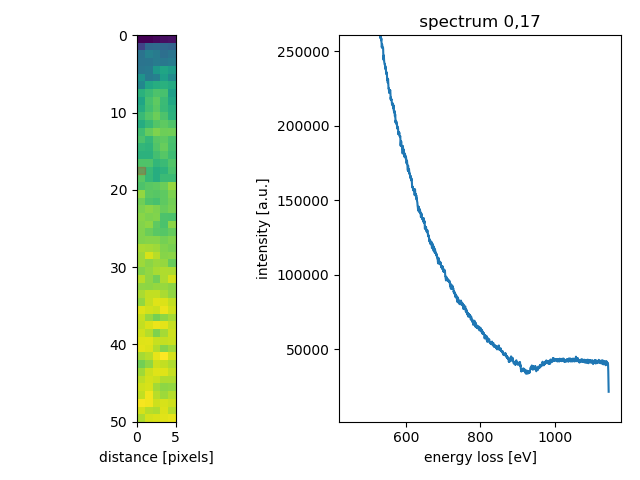

In [27]:
import matplotlib.patches as patches
from ipywidgets import widgets


class h5_spectrum_image(object):
    """    
    ### Interactive spectrum imaging plot
    
    Input tags: dictionary with a minumum of the following keys:
        ['image']: displayed image  
        ['data']:  data cube
        ['intentsity_scale_ppm']: intensity scale         
        ['ylabel']: intensity label
        ['spectra'] dictionary which contains dictionaries for each spectrum style ['1-2']:
            ['spectrum'] = tags['cube'][y,x,:]
            ['spectra'][f'{x}-{y}']['energy_scale'] = tags['energy_scale']
            ['intensity_scale'] = 1/tags['cube'][y,x,:].sum()*1e6
    
    Please note the possibility to load any image for the selection of the spectrum
    Also there is the possibilty to display the survey image.
    
    For analysis we have the following options:
        'fix_energy': set zero-loss peak maximum to zero !! Low loss spectra only!!
        'fit_zero_loss': fit zero-loss peak with model function !! Low loss spectra only!!
        'fit_low_loss': fit low-loss spectrum with model peaks !! Low loss spectra only!!
        
        
        'fit_composition': fit core-loss spectrum with background and cross sections!! Core loss spectra only!!
        'fit_ELNES': fit core-loss edge with model peaks  !! Core loss spectra only!!
    """
    
    def __init__(self, current_channel, horizontal = True):
        
        
        if current_channel['data_type'][()] != 'spectrum_image':
            return
        
        box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')

        self.figure = plt.gcf()
        self.horizontal = horizontal
        self.x = 0
        self.y = 0
        
        sizeX = current_channel['spatial_size_x'][()]
        sizeY = current_channel['spatial_size_y'][()]
        
        spec_sizeX = current_channel['spectral_size_x'][()]
        spec_scaleX = current_channel['spectral_scale_x'][()]
        spec_offsetX = current_channel['spectral_origin_x'][()]

        self.energy_scale = np.arange(spec_sizeX)*spec_scaleX+spec_offsetX

        
        
        self.extent = [0,sizeY,sizeX,0]
        self.rectangle = [0,sizeY,0,sizeX]
        self.scaleX = 1.0
        self.scaleY = 1.0
        self.analysis = []
        self.plot_legend = False
        if 'ylabel' not in tags:
            tags['ylabel'] = 'intensity [a.u.]'
        self.SI = False
        
        if horizontal:
            self.ax1=plt.subplot(1, 2, 1)
            self.ax2=plt.subplot(1, 2, 2)
        else:
            self.ax1=plt.subplot(2, 1, 1)
            self.ax2=plt.subplot(2, 1, 2)
            
        self.cube =  np.reshape(current_channel['Raw_Data'][:,:],(sizeX,sizeY,spec_sizeX))
        self.image = self.cube.sum(axis=2)
        
        self.ax1.imshow(self.image, extent = self.extent)
        if horizontal:
            self.ax1.set_xlabel('distance [pixels]')
        else:
            self.ax1.set_ylabel('distance [pixels]')
        self.ax1.set_aspect('equal')
        
        self.rect = patches.Rectangle((0,0),1,1,linewidth=1,edgecolor='r',facecolor='red', alpha = 0.2)
        self.ax1.add_patch(self.rect)
        self.intensity_scale = 1.
        self.spectrum = self.cube[self.x, self.y, :]* self.intensity_scale
        
        
        self.ax2.plot(self.energy_scale,self.spectrum)
        self.ax2.set_title(f' spectrum {self.x},{self.y} ')
        self.ax2.set_xlabel('energy loss [eV]')
        self.ax2.set_ylabel(tags['ylabel'])
        self.cid = self.ax2.figure.canvas.mpl_connect('button_press_event', self.onclick)
        
        
        plt.tight_layout()
    
                
                
    def onclick(self,event):
        x = int(event.xdata)
        y = int(event.ydata)
        
        if x >= self.rectangle[0] and x < self.rectangle[0]+self.rectangle[1]:
            if y >= self.rectangle[2] and y < self.rectangle[2]+self.rectangle[3]:
                self.x = int((x - self.rectangle[0])/ self.rectangle[1]*self.cube.shape[1])
                self.y = int((y - self.rectangle[2])/ self.rectangle[3]*self.cube.shape[0])
            else:
                return
        else:
            return
        
        
        self.ax2.set_xlabel(f' {x}, self {self.y}')
        self.ax2.set_xlabel(f' {x}, - {y}')
        if event.inaxes in [self.ax1]:
            self.ax2.set_xlabel(f'in axis, {x}, {y}')
            x = (self.x * self.rectangle[1]/self.cube.shape[1]+ self.rectangle[0])
            y = (self.y * self.rectangle[3]/self.cube.shape[0]+ self.rectangle[2])
            
            self.rect.set_xy([x,y]) 
            xlim = self.ax2.get_xlim()
            ylim = self.ax2.get_ylim()
            self.ax2.clear()
            self.intensity_scale = 1.
            self.spectrum = self.spectrum = self.cube[self.y, self.x, :]* self.intensity_scale
            #self.energy_scale = tags['spectra'][f'{self.x}-{self.y}']['energy_scale']
           
            
            self.ax2.plot(self.energy_scale,self.spectrum, label = 'experiment')
            self.ax2.set_title(f' spectrum {self.x},{self.y} ')
                
            if self.plot_legend:
                self.ax2.legend(shadow=True);
            self.ax2.set_xlim(xlim)
            self.ax2.set_ylim(ylim)
            self.ax2.set_xlabel('energy loss [eV]')
            self.ax2.set_ylabel(tags['ylabel'])
            
            
        self.ax2.draw()
        
   
    
    def set_legend(self, setLegend):
        self.plot_legend = setLegend
    
    def get_xy(self):
        return [self.x,self.y]
    
    def get_current_spectrum(self):
        return self.cube[self.y,self.x,:]
    


plt.figure()
SI_plot= h5_spectrum_image(current_channel, horizontal = True)

Box(children=(ToggleButton(value=False, description='fix_energy'), ToggleButton(value=False, description='fit_…

<IPython.core.display.Javascript object>


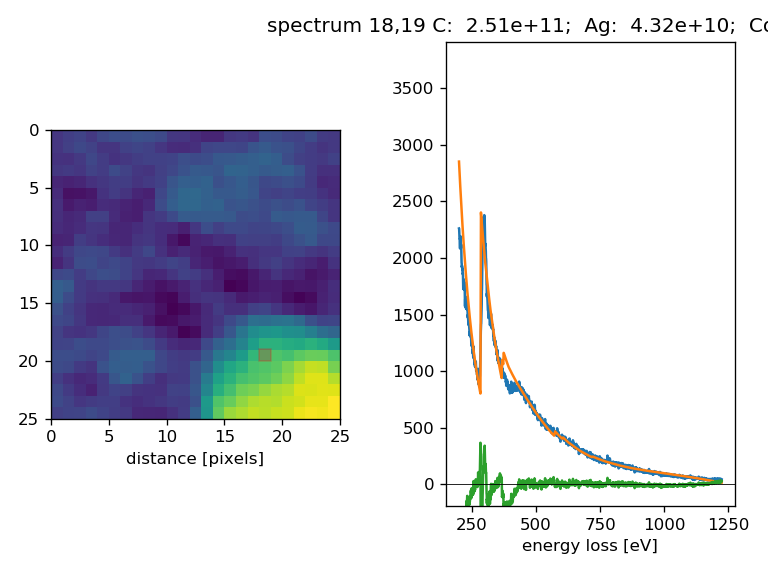

In [37]:
import importlib
importlib.reload(eels)

#edges = eels.make_edges(SI_plot.tags['edges_present'], SI_plot.energy_scale, SI_plot.tags['acceleration_voltage'], SI_plot.tags['collection_angle'])
#edges = eels.fit_edges(SI_plot.spectrum, SI_plot.energy_scale, SI_plot.tags['region_tags'], edges)
        
#print(edges)        
SI_plot= eels.interactive_spectrum_image(current_channel, horizontal = True)

## Add information for fitting of spectrum with cross sections (and background) for quantification

In [28]:
## Set edges to be fitted
edges_present = ['C-K','Ag-M5','Co-L3']
SI_plot.tags['edges_present'] = edges_present

edges = eels.make_edges(edges_present, tags['energy_scale'], tags['acceleration_voltage'], tags['collection_angle'])

## define the fitting regions
regions = eels.Region_Selector(SI_plot.ax2)
for key in edges:
    regions.set_regions(str(key),edges[key]['onset']-edges[key]['start_exclude'], edges[key]['start_exclude']+edges[key]['end_exclude'])                               
regions.set_regions('fit region',tags['energy_scale'][100], tags['energy_scale'][-1]-tags['energy_scale'][100])
region_tags = regions.get_regions()

SI_plot.tags['region_tags'] = region_tags

## ACTIVATE THE FITTING
#SI_plot.analysis= 'fit_quantification'
SI_plot.set_legend(False)

## After adjusting the regions, remove the selector and make legend visible

In [30]:
SI_plot.set_legend(True)
region_tags = regions.get_regions()
SI_plot.tags['region_tags'] = region_tags
tags2 = SI_plot.tags.copy()
regions.disconnect()

## Interactive Spectrum image Plot:
   
The code above is also available in the EELS tools

<IPython.core.display.Javascript object>


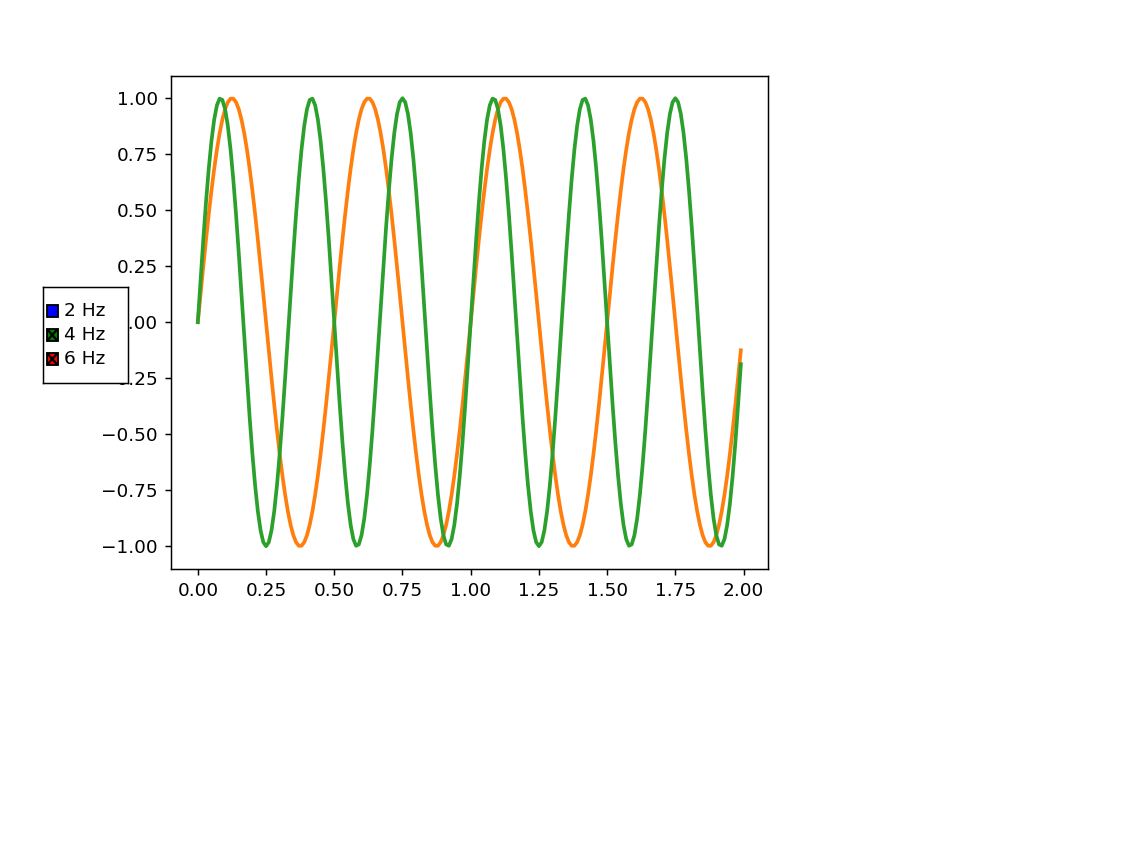

0

In [10]:
## MAKE Dictionary
        
        if isinstance(data_source,dict):
            self.tags = data_source
        elif isinstance(data_source, h5py.Group):  
            self.tags = self.set_tags(data_source)
        else: 
            print('Data source must be a dictionary or channel')
            return
        
        energy_scale = self.tags['spectra'][f'{self.x}-{self.y}']['energy_scale']
spectrum = self.tags['spectra'][f'{self.x}-{self.y}']['spectrum']

edges = make_edges(self.tags['edges_present'], energy_scale, self.tags['acceleration_voltage'], self.tags['collection_angle'])
edges = fit_edges(spectrum, energy_scale, self.tags['region_tags'], edges)
self.tags['spectra'][f'{self.x}-{self.y}']['edges'] = edges
self.ax2.plot(energy_scale,edges['model']['spectrum'], label = 'model')
self.ax2.plot(energy_scale,self.spectrum-edges['model']['spectrum'], label = 'difference')
self.ax2.axhline(linewidth = 0.5, color= 'black');

title = f'spectrum {self.x},{self.y} '

for key in edges:
    if key.isdigit():
        title = title +f"{edges[key]['element']}:  {edges[key]['areal_density']:.2e};  "
return title

<IPython.core.display.Javascript object>


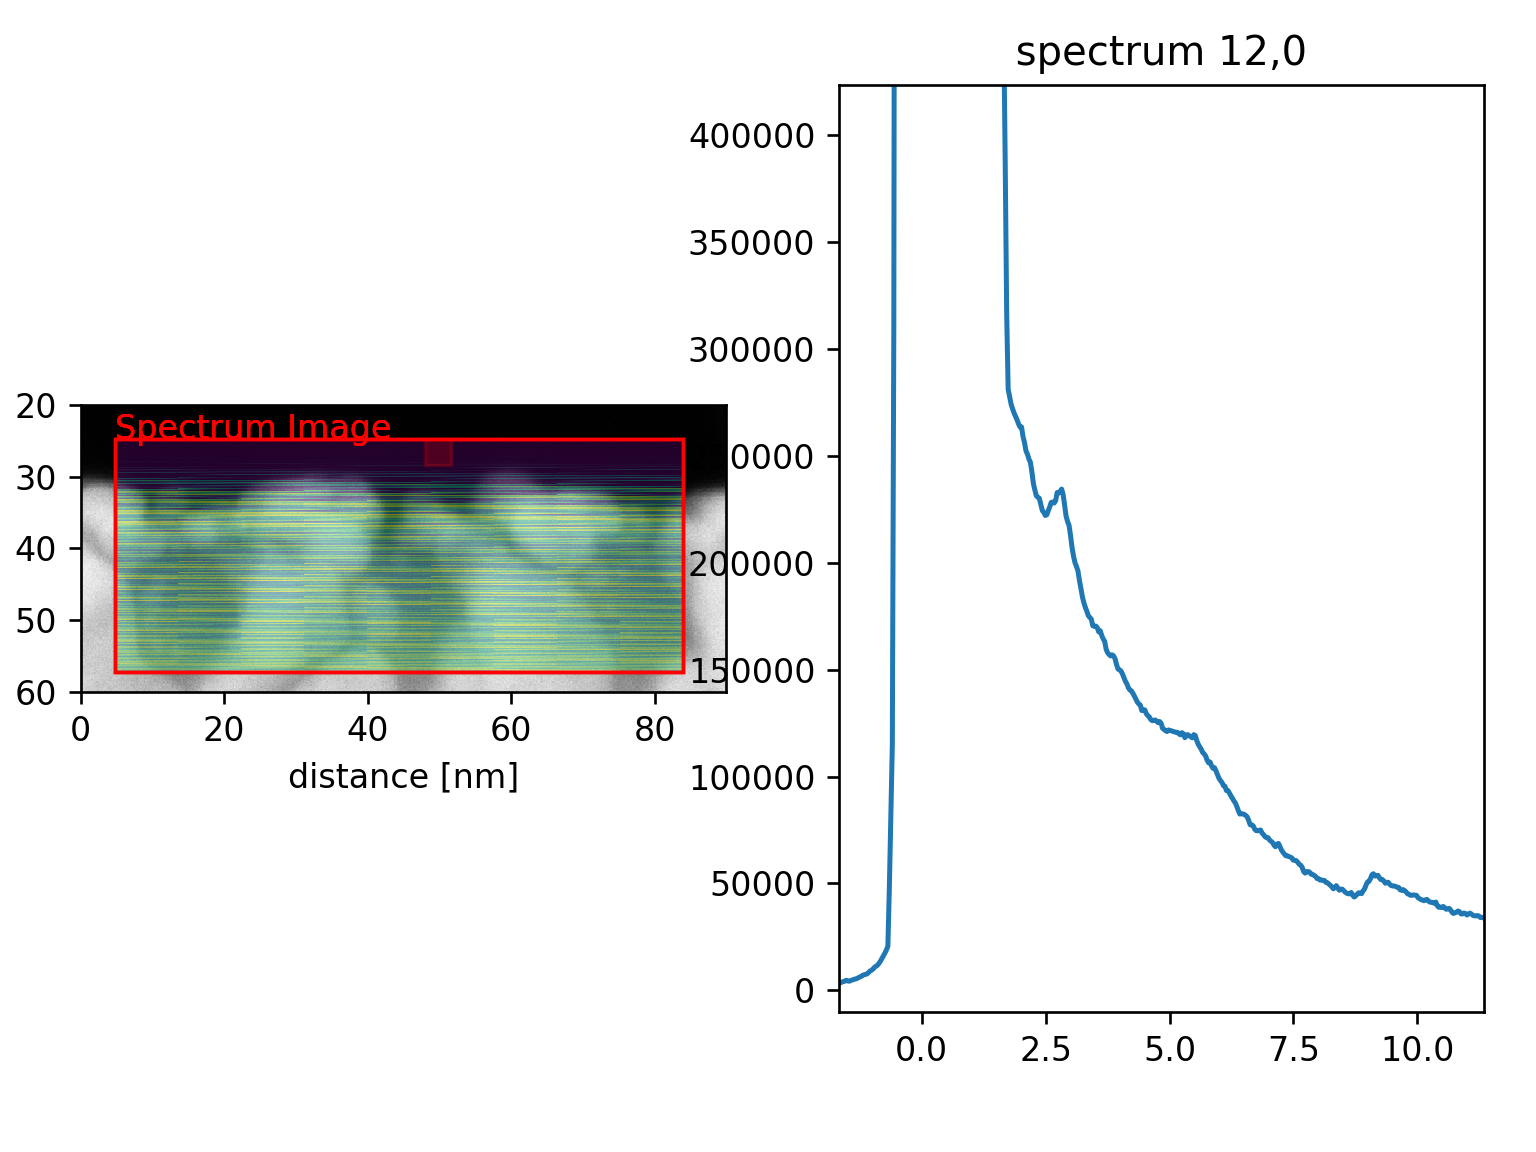

In [27]:
SI_plot= eels.interactive_spectrum_image(tags['cube'],tags['energy_scale'], horizontal =True)


## Add survey image to file

In [44]:

SI_channel = ft.h5_add_channel(h5_file,current_channel,'survey image')    
measurement_group = h5_file[current_channel.name.split('/')[1]]
    
for key in list(measurement_group.keys()):
    if 'title' in measurement_group[key].keys(): 
        print(key,': ',measurement_group[key]['title'][()])
    else:
        print(key,': ')   
ft.h5_plot(SI_channel)       

Channel_000 :  4-EELS Spectrum Image
Channel_001 :  4-10nmSI Survey Image (active)
Channel_002 :  4-Analog
Channel_003 :  4-10nmSI Survey Image (active)


NameError: name 'it' is not defined

<IPython.core.display.Javascript object>


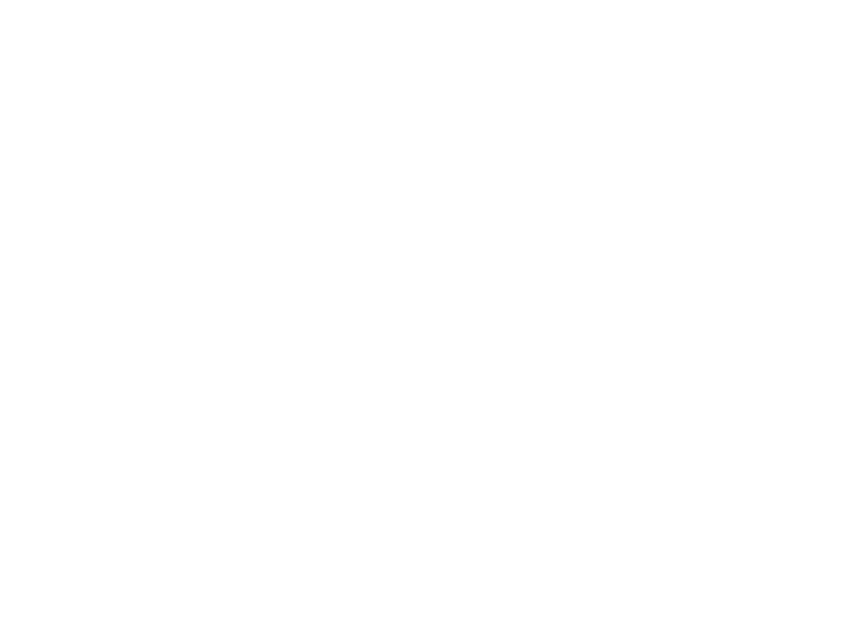

AttributeError: module 'matplotlib.pyplot' has no attribute 'patches'

In [45]:
ft.h5_plot(SI_channel)     

## Add Survey Image to plot above

I overlay the sum of all spectra on top of the box of the survey image.

Comment that line out (*#SI_plot.overlay_data()*) if you don't want that.

In [39]:
tags['survey_channel'] = h5_file['Measurement_000']['Channel_001']
SI_plot.set_Survey_image()

SI_plot.overlay_data() 

## set view port 
SI_plot.ax1.set_xlim(0,90)
SI_plot.ax1.set_ylim(60,20)


(60, 20)

## Add Z-contrast image

In [40]:
Z_channel = ft.h5add_channel(h5_file,current_channel,'Z-contrast image')
    
measurement_group = h5_file[current_channel.name.split('/')[1]]
    
for key in list(measurement_group.keys()):
    if 'title' in measurement_group[key].keys(): 
        print(key,': ',measurement_group[key]['title'][()])
    else:
        print(key,': ') 

Channel_000 :  4-EELS Spectrum Image
Channel_001 :  4-10nmSI Survey Image (active)
Channel_002 :  4-Analog


## Overlay Z-contrast image on survey image at plot above

In [43]:
tags['survey_channel'] = h5_file['Measurement_000']['Channel_001']
tags['Z-contrast_channel'] = h5_file['Measurement_000']['Channel_002']

SI_plot.set_Survey_image(h5_file['Measurement_000']['Channel_001'])
SI_plot.overlay_Zcontrast_image(h5_file['Measurement_000']['Channel_002'])

## set view port 
SI_plot.ax1.set_xlim(0,90)
SI_plot.ax1.set_ylim(60,20)


(60, 20)

## Probability scale of y-axis

We need to know the total amount of electrons involved in the EELS spectrum 

There are three possibilities:
- the intensity of the low loss will give us the counts per acquisition time
- the intensity of the beam in an image (i.e. "Ronchigram" of vacuum)
- a direct measurement of the incident beam current

Here we got the low-loss spectrum. For the example please load **1EELS Acquire (low-loss).dm3** from the *example data* folder.

In [3]:
ll_channel = ft.h5_add_channel(h5_file,current_channel,'LL',filename=None)

# get dictionary from current channel in pyUSID file
LLspectrum_tags = ft.h5_get_dictionary(ll_channel)

print(f"{LLspectrum_tags['data'].sum():.0f} counts in  {LLspectrum_tags['integration_time']:.2f}sec")
I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']
print(f"integration time for spectrum was {tags['integration_time']:.2f} s ")

I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']*tags['integration_time']
print(f"incident beam current of core--loss is {I0:.0f} counts")

if 'incident_beam_current_counts' in current_channel:
    current_channel['incident_beam_current_counts'][()] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['incident_beam_current_counts'] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']

    
out_tags ={}
out_tags['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']
if 'intentsity_scale_ppm' in current_channel:
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']


dict_keys(['aberrations', 'exposure_spectrum', 'number_of_frames', 'collection_angle', 'convergence_angle', 'acceleration_voltage', 'image_type', 'camera_length', 'integration_time', 'time_last_modified', 'title', 'data_type', 'data', 'spectral_scale_x', 'spectral_units_x', 'spectral_origin_x', 'spectral_size_x', 'energy_scale'])


<IPython.core.display.Javascript object>


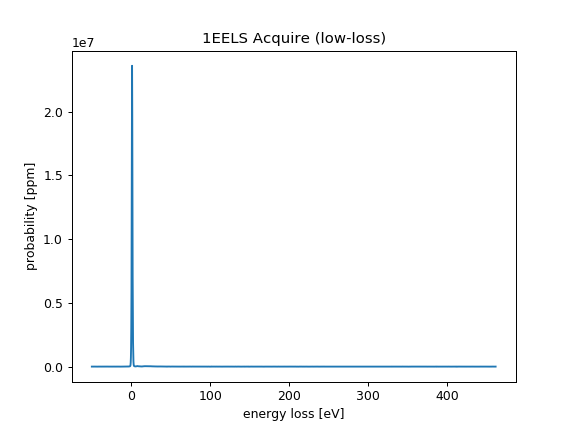

In [4]:
print(LLspectrum_tags.keys())

plt.figure()
plt.title(LLspectrum_tags['title'])
plt.plot(LLspectrum_tags['energy_scale'] , LLspectrum_tags['data'] );
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Intensity to Probability Calibration

 We need to calibrate the number of counts with the integration time of the spectrum.

<IPython.core.display.Javascript object>


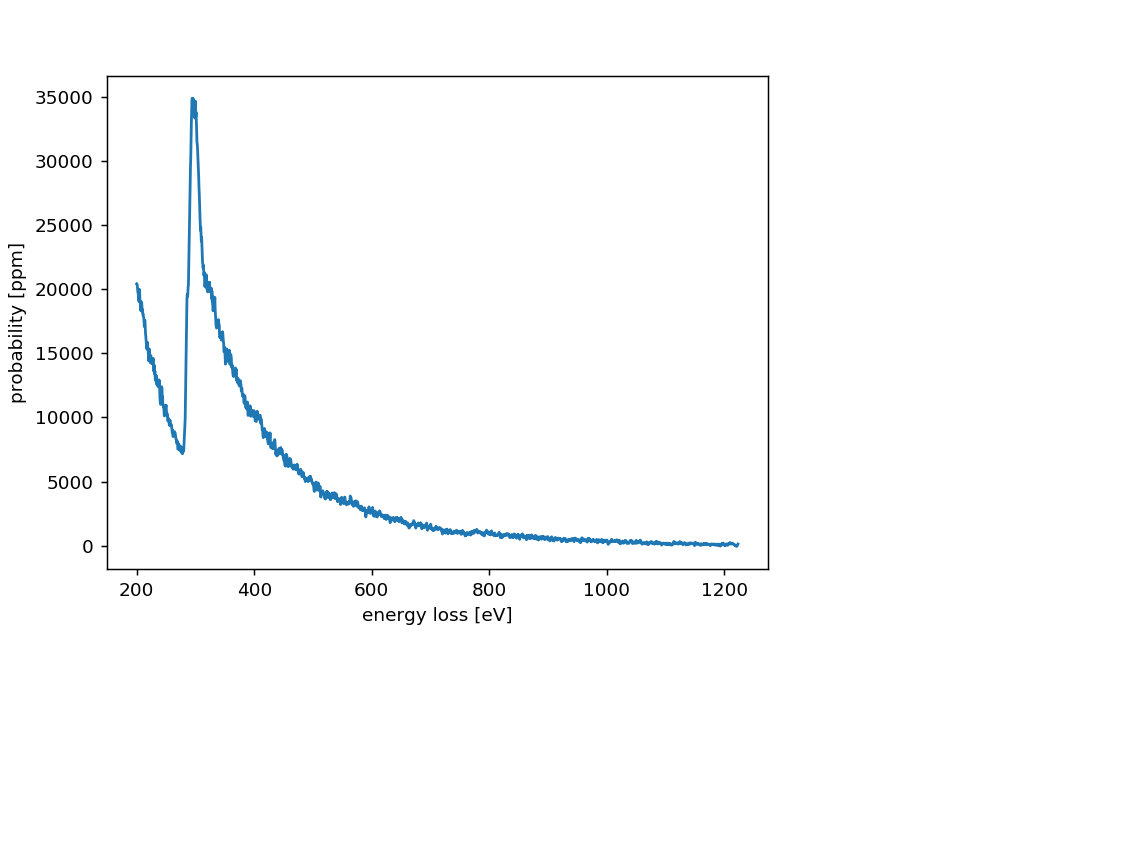

In [20]:


spectrum = tags['data']*current_channel['intentsity_scale_ppm'][()]
plt.figure()
plt.plot(tags['energy_scale'], spectrum)
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Which elements are present

To determine which elements are present we add a cursor to the above plot (see [Working with Cross-Sections](CH4-Working_with_X-Sections.ipynb) for details) and with a left (right) mouse-click, we will get the major (all) edges in the vincinity of the cursor.

In the example we note that the N-K edge of this boron nitride sample is not at 400keV. We have to adjust the energy-scale. <br>(THIS SHOULD NOT HAPPEN IN NORMAL SPECTRA AND IS FOR DEMONSTRATION ONLY)

In [4]:
maximal_chemical_shift = 5
cursor = eels.EdgesatCursor(plt.gca(), tags['energy_scale'],spectrum,maximal_chemical_shift)


Let's correct the energy scale of the example spectrum.

Again a shift of the energy scale is normal but not a discripancy of the dispersion.

## Declaration of Edges
Here we declare which ionization-edges are present. Please make sure that the energy scale is correct!!!



<IPython.core.display.Javascript object>


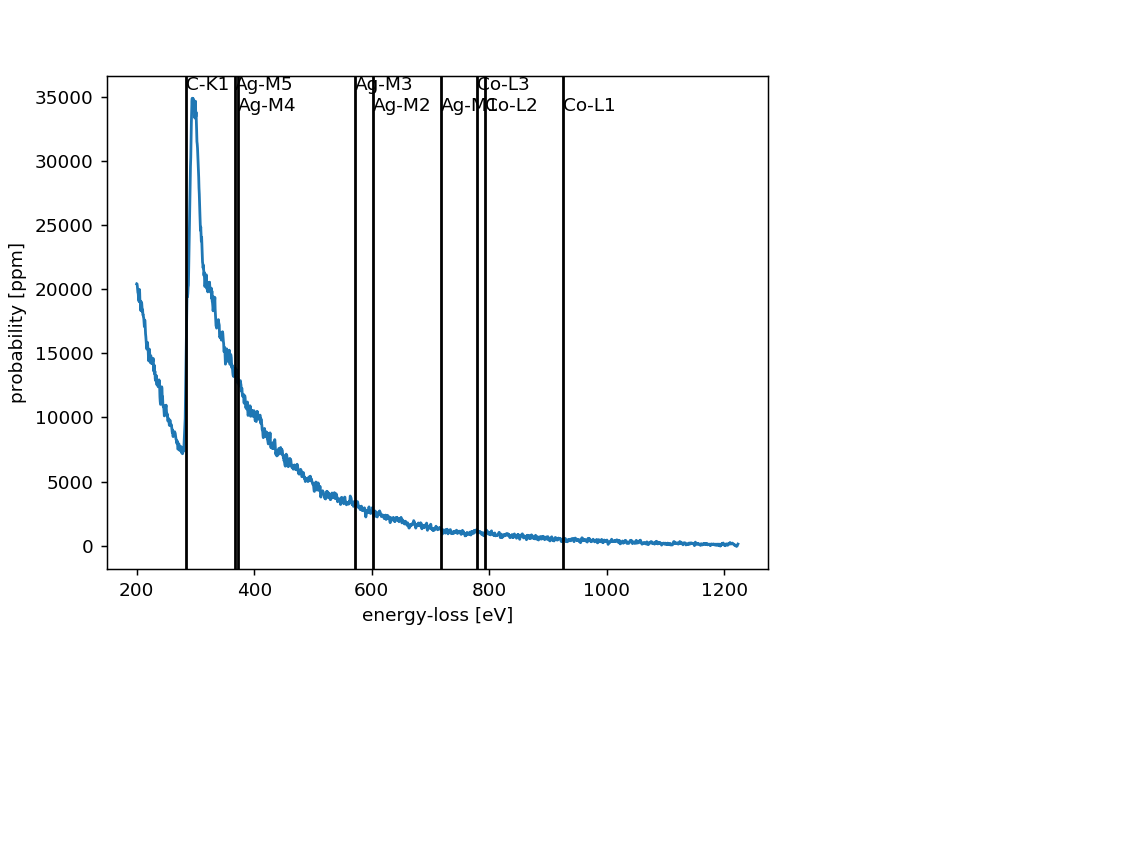

In [21]:
## Input
edges_present = ['C-K','Ag-M5','Co-L3']


tags['energy_scale'] = energy_scale_orig
energy_scale = tags['energy_scale']
SI_plot.tags['edges_present'] = edges_present
tags['edges_present'] = edges_present
edges = eels.make_edges(edges_present, energy_scale, tags['acceleration_voltage'], tags['collection_angle'])

plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

plot_edges= []
for key in edges:
    plot_edges.append( eels.elemental_edges(plt.gca(), edges[key]['Z']))

## Preparing the fitting mask

Our theoretical cross sections do not include any solid state effects (band structure) and so the fine structure at the onset of the spectra must be omitted in a quantification.

These parts of the spectrum will be simply set to zero. We plot the masked spectrum that will be evaluated.

<IPython.core.display.Javascript object>


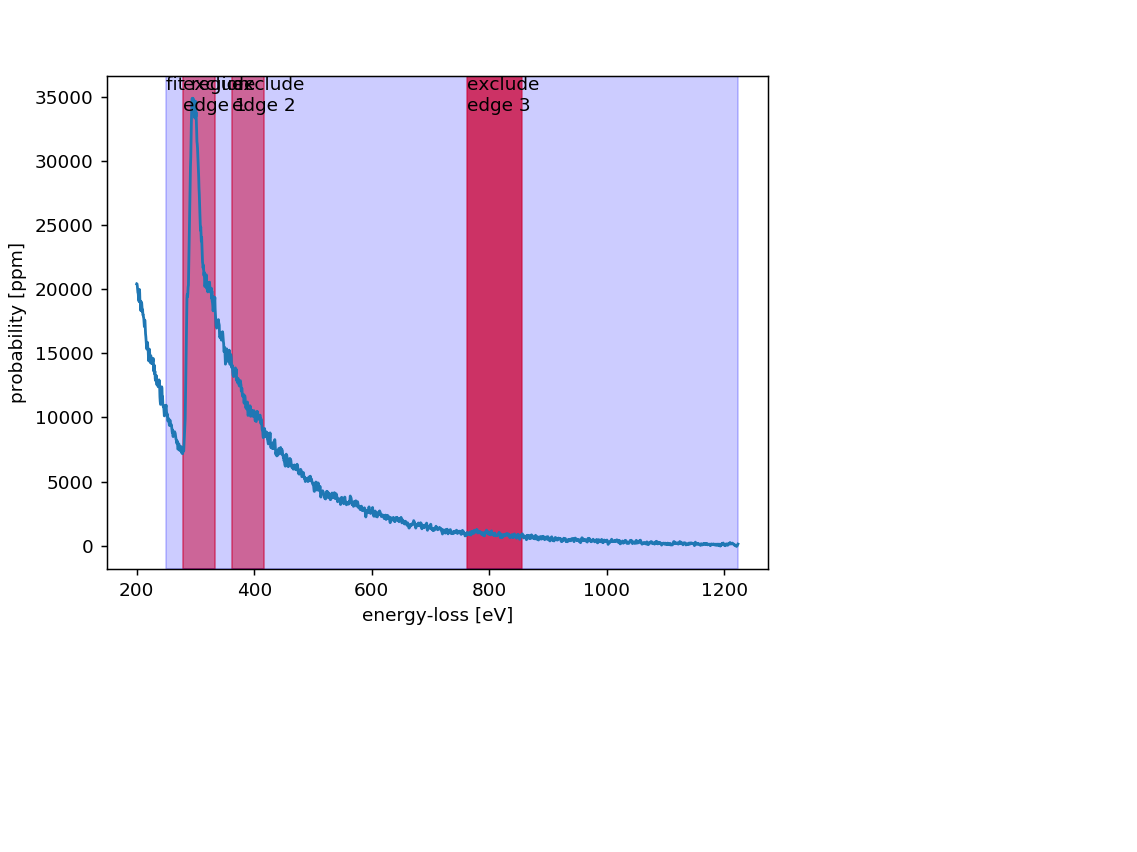

In [23]:
plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

regions = eels.Region_Selector(plt.gca())

for key in edges:
    regions.set_regions(str(key),edges[key]['onset']-edges[key]['start_exclude'], edges[key]['start_exclude']+edges[key]['end_exclude'])
                                  
regions.set_regions('fit region',energy_scale[100], tags['energy_scale'][-1]-energy_scale[100])



## The Fit

The function **model** just sums the weighted cross-sections and the background.

The background consists of the power-lawbackground before plus a polynomial component allowing for *a variation of the exponent $r$ of the power-law*.

The least square fit is weighted by the noise according to Poison statistic $\sqrt{I(\Delta E)}$.



In [10]:
region_tags = regions.get_regions()
print(region_tags)
SI_plot.tags['region_tags'] = region_tags
tags['region_tags'] = region_tags
edges = eels.fit_edges(spectrum, energy_scale, region_tags, edges)


print(f"{edges['1']['element']}/{edges['2']['element']} ratio is {edges['1']['areal_density']/edges['2']['areal_density']:.3f}")

#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
for key in edges:
    if key.isdigit():
        print(f"{edges[key]['element']} ({edges[key]['Z']}) areal density is {edges[key]['areal_density']:.0f} atoms per square nm, which equates {abs(edges[key]['areal_density'])/18.2:.1f} atomic layers")


{'1': {'start_x': 278.8, 'width_x': 55}, '2': {'start_x': 361.70000000000005, 'width_x': 55}, '3': {'start_x': 773.5999999999999, 'width_x': 55}, 'fit_area': {'start_x': 250.0, 'width_x': 973.5}}
1
C/Ag ratio is -15.233
C (6) areal density is 3754397191599 atoms per square nm, which equates 206285559978.0 atomic layers
Ag (47) areal density is -246472548083 atoms per square nm, which equates 13542447696.9 atomic layers
Co (27) areal density is 0 atoms per square nm, which equates 0.0 atomic layers


## Plotting of the fit


<IPython.core.display.Javascript object>


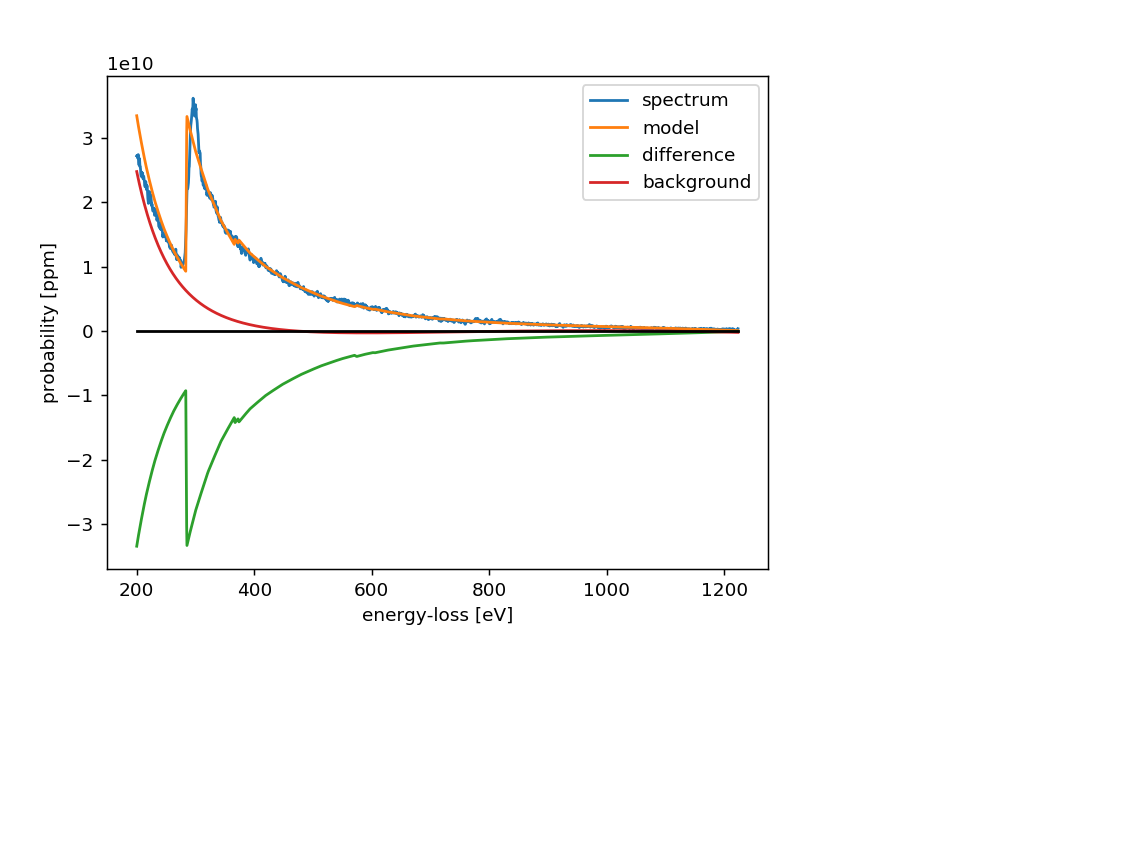

In [11]:

plt.figure()
plt.plot(energy_scale, spectrum*1e6, label='spectrum')
plt.plot(energy_scale,edges['model']['spectrum']*1e6, label='model')
plt.plot(energy_scale,spectrum-edges['model']['spectrum']*1e6, label='difference')
plt.plot(energy_scale,edges['model']['background']*1e6, label='background')
plt.plot([energy_scale[0],energy_scale[-1]],[0,0],c='black')

plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]')
plt.legend();

## Dictionary for Log of Fitting Results

In [11]:
out_tags = {}
for key1 in edges:
    if key1.isdigit():
        for key2 in edges[key1]:
            out_tags[f"edge_{key1}_{key2}"] = edges[key1][key2]
    else:
        for key2 in edges[key1]:
            out_tags[f"{key1}_{key2}"] = edges[key1][key2]

out_tags['monolayer']= 18.2 #atoms/nm^2
out_tags['X_section_unit'] = 'atoms/nm$^2$'

In [12]:
print(out_tags.keys())

dict_keys(['edge_1_Z', 'edge_1_symmetry', 'edge_1_element', 'edge_1_chemcial_shift', 'edge_1_original_onset', 'edge_1_onset', 'edge_1_start_exclude', 'edge_1_end_exclude', 'edge_1_data', 'edge_1_areal_density', 'edge_2_Z', 'edge_2_symmetry', 'edge_2_element', 'edge_2_chemcial_shift', 'edge_2_original_onset', 'edge_2_onset', 'edge_2_start_exclude', 'edge_2_end_exclude', 'edge_2_data', 'edge_2_areal_density', 'model_background', 'model_background-poly_1', 'model_background-poly_2', 'model_background-A', 'model_background-r', 'model_spectrum', 'model_blurred', 'model_mask', 'model_fit_parameter', 'model_fit_area_start', 'model_fit_area_end', 'monolayer', 'X_section_unit'])


## Log Results

In [13]:
log_group = ft.h5_add_Log(current_channel, name='Xsection_fit')
ft.h5_add_Data2Log(log_group,  out_tags)

## Check on File Content

In [14]:
import pyUSID as usid 
usid.hdf_utils.print_tree(h5_file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ X_section_unit
      ├ _Xsection_fit
      ├ edge_1_Z
      ├ edge_1_areal_density
      ├ edge_1_chemcial_shift
      ├ edge_1_data
      ├ edge_1_element
      ├ edge_1_end_exclude
      ├ edge_1_onset
      ├ edge_1_original_onset
      ├ edge_1_start_exclude
      ├ edge_1_symmetry
      ├ edge_2_Z
      ├ edge_2_areal_density
      ├ edge_2_chemcial_shift
      ├ edge_2_data
      ├ edge_2_element
      ├ edge_2_end_exclude
      ├ edge_2_onset
      ├ edge_2_original_onset
      ├ edge_2_start_exclude
      ├ edge_2_symmetry
      ├ model_background
      ├ model_background-A
      ├ model_background-poly_1
      ├ model_background-poly_2
      ├ model_background-r
      ├ model_blurred
      ├ model_fit_area_end
      ├ model_fit_area_start
      ├ model_fit_parameter
      ├ model_mask
      ├ model_spectrum
      ├ monolayer
      ├ time_stamp
      ├ title
    ├ Position_

# Close File
File needs to be closed to be used with other notebooks

In [15]:
h5_file.close()

## Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)
## Next:  [ELNES](ELNES.ipynb)

## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)
## Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)